# Optimizers et schedulers

In [1]:
import matplotlib.pyplot as plt
import plotnine as pn
import torch

from adl import optimizers

pn.theme_set(
    pn.theme_minimal()
    + pn.theme(
        plot_background=pn.element_rect(fill="white"),
        plot_title=pn.element_text(size=11),
    )
)

# Optimizers

Les optimizers et les schedulers sont des techniques et des méthodes permettant d'améliorer le
processus d'apprentissage et de trouver de meilleures valeurs optimales. L'objectif de ce
cahier est de présenter quelques idées sur le fonctionnement de ces méthodes.

## Optimiseurs

Dans les cahiers précédents, nous avons ajusté manuellement les paramètres de nos modèles à partir de nos
valeurs de gradient, à l'aide d'un code tel que celui-ci :

``` python
w = w - step_size * w.grad
b = b - step_size * b.grad
```

Autrement dit, à chaque étape d'apprentissage, nos paramètres (ici $w$ et $b$) étaient
ajustés en ajoutant à leur valeur la valeur du gradient de perte
multipliée par une *taille de pas*, ou *taux d'apprentissage*. 

Ce taux d'apprentissage mesure la distance que nous voulons parcourir dans la direction du gradient à chaque
étape, ce qui peut être considéré de manière approximative comme la vitesse à laquelle nous voulons apprendre à partir des
valeurs de gradient.

Cette méthode simple permet de trouver les valeurs optimales pour les cas les plus simples,
 mais elle peut être considérablement améliorée à l'aide de différentes techniques. 
 
Une méthode permettant de mettre à jour les paramètres du modèle à partir de leurs valeurs de gradient est
appelée *optimiseur*.

Pour illustrer cela, nous utiliserons une fonction de perte plus complexe à deux
paramètres avec plusieurs optimums différents. Elle est représentée ci-dessous sous forme de
graphique de contours : les axes horizontaux et verticaux indiquent les valeurs de nos
deux paramètres, et les contours colorés représentent la valeur de perte à
différents points. Lorsque le contour est rouge, la perte est élevée, lorsqu'il est
bleu foncé, elle est faible. Notre objectif ici est donc d'atteindre le minimum visible
qui se situe autour de (-3, -2).


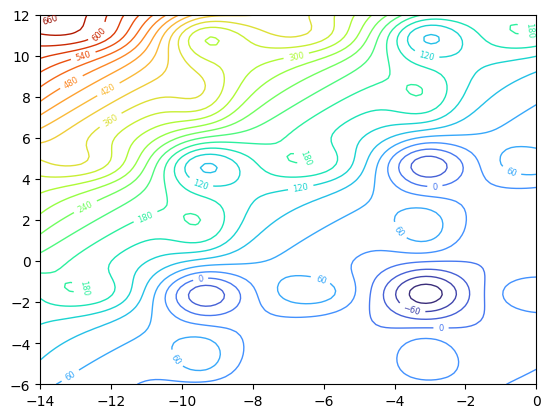

In [2]:
plot_sin_loss_args = {
    "loss_fn": optimizers.sin_loss_fn,
    "w1min": -14,
    "w1max": 0,
    "w2min": -6,
    "w2max": 12,
    "nsteps": 100,
}
optimizers.plot_loss(**plot_sin_loss_args)

Le graphique ci-dessous représente une descente de gradient à partir de (-6,5, 4,5)
et en utilisant une taille de pas, ou taux d'apprentissage, de 0,01. Ainsi, à chaque pas, nous
calculons le gradient de perte au point actuel et nous « nous déplaçons » dans cette
direction en fonction du taux d'apprentissage. Nous pouvons voir que dans ce cas,
nous atteignons la valeur minimale en environ 30 pas.

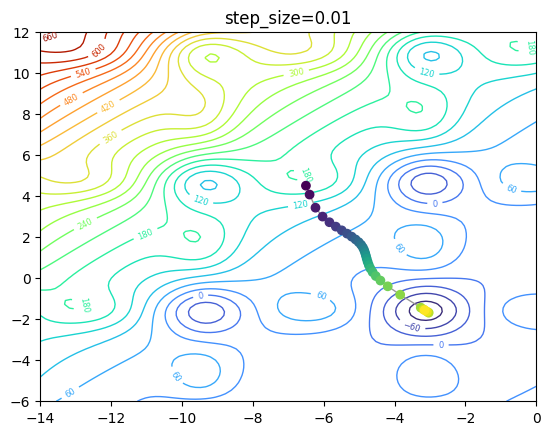

In [3]:
plot_sin_train_args1 = plot_sin_loss_args | {
    "w1_init": -6.5,
    "w2_init": 4.5,
}
optimizers.plot_train(**plot_sin_train_args1, epochs=30, step_size=0.01)

### Stochastic gradient descent

Cette méthode est appelée *descente stochastique du gradient* et, au lieu de
la calculer nous-mêmes, nous pouvons appeler une méthode d'optimisation pytorch prédéfinie
appelée `torch.optim.SGD` qui, par défaut, fait exactement la même chose.

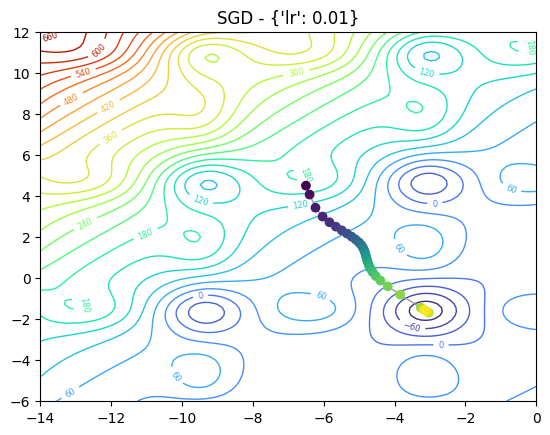

In [4]:
plot_sin_train_args1 = plot_sin_loss_args | {
    "w1_init": -6.5,
    "w2_init": 4.5,
}
optimizers.plot_train(
    **plot_sin_train_args1,
    epochs=30,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.01},
)

Que se passerait-il si nous changions le point de départ ? Dans le graphique ci-dessous, nous
partons de (-12, 10) et nous pouvons voir que la descente de gradient s'arrête à
un autre endroit, qui est un minimum local mais avec une valeur plus élevée que le
meilleur visible.

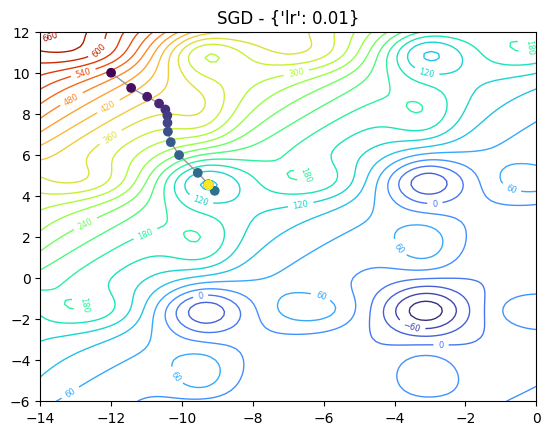

In [5]:
plot_sin_train_args2 = plot_sin_loss_args | {
    "w1_init": -12.0,
    "w2_init": 10.0,
}
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=30,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.01},
)

Cela illustre le fait que le processus d'apprentissage n'est pas
déterministe : si nous commençons à un point aléatoire, *c'est-à-dire* avec les paramètres de notre modèle
initialisés avec des valeurs aléatoires, la descente sera différente
et pourrait ne pas aboutir à la même valeur optimale.

Cela illustre également un inconvénient de la méthode de descente de gradient : si nous
nous arrêtons au premier endroit où les valeurs du gradient sont nulles,
nous savons que nous sommes à un point minimum, mais il pourrait s'agir d'un minimum local
plutôt que d'un minimum global. En fait, il n'y a aucun moyen de savoir si le minimum
est local ou global.

Plusieurs techniques ont été développées pour améliorer ce comportement. L'une d'entre elles
consiste à ajouter une « impulsion » à notre processus d'apprentissage : cela peut être considéré comme un
moyen d'ajouter une « inertie » à notre descente, ce qui peut permettre d'échapper à un
minimum local dans certains cas. Dans l'exemple suivant, nous avons le même
point de départ et le même taux d'apprentissage que précédemment, mais l'ajout d'une impulsion
permet d'aller au-delà du premier minimum local et de se diriger vers la valeur la plus basse.